In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
def resize_and_normalize_image(image):
    image = tf.image.resize(image,[96, 96])
    image = tf.image.rgb_to_grayscale(image)
    return image / 255.0

def convert_sample(data):

# Create a TensorFlow dataset from the training data features
    dataset = tf.data.Dataset.from_tensor_slices(data)

# Define a function to resize each image in the dataset

# Apply the resize function to each image in the dataset
    resized_dataset = dataset.map(resize_and_normalize_image)

    resized_dataset.batch(32)

# Convert the resized dataset to a NumPy array
    resized_arr = np.array(list(resized_dataset.as_numpy_iterator()))

    return resized_arr

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

import sys
sys.path.append('/content/gdrive/My Drive/Assignment 4/')

from layers import BilinearInterpolation

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
X_train_raw = np.load('/content/gdrive/My Drive/Assignment 4/Xtrain.npy')
print(f'Shape of the raw training data: {X_train_raw.shape}')

X_test_raw = np.load('/content/gdrive/My Drive/Assignment 4/Xtest.npy')
print(f'Shape of the raw test data: {X_test_raw.shape}')

X_train = convert_sample(X_train_raw)
print(f'Shape the resized training data: {X_train.shape}')

X_test = convert_sample(X_test_raw)
print(f'Shape the resized test data: {X_test.shape}')

y_raw = np.load('/content/gdrive/My Drive/Assignment 4/ytrain.npy')
y_raw = y_raw.reshape(-1,1)
print(f'Shape of the raw labels: {y_raw.shape}')

Shape of the raw training data: (26214, 96, 96, 3)
Shape of the raw test data: (1638, 96, 96, 3)
Shape the resized training data: (26214, 96, 96, 1)
Shape the resized test data: (1638, 96, 96, 1)
Shape of the raw labels: (26214, 1)


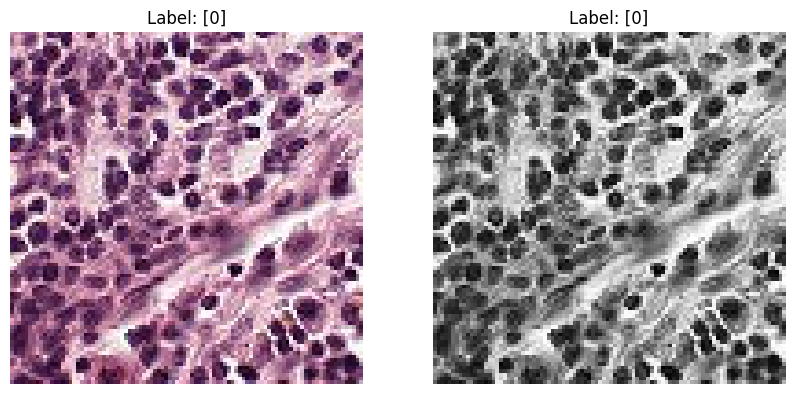

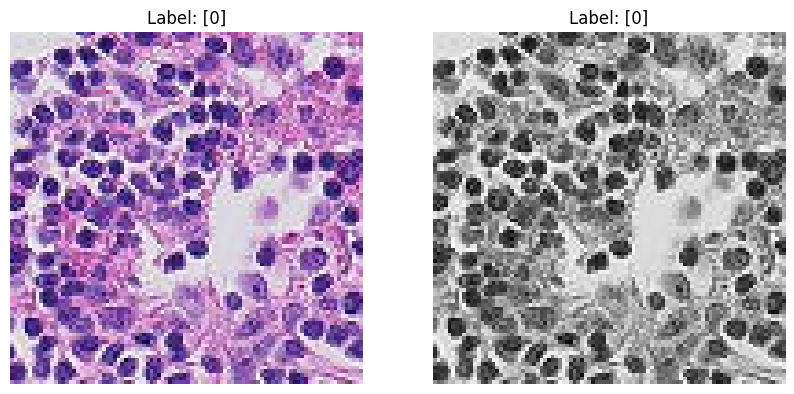

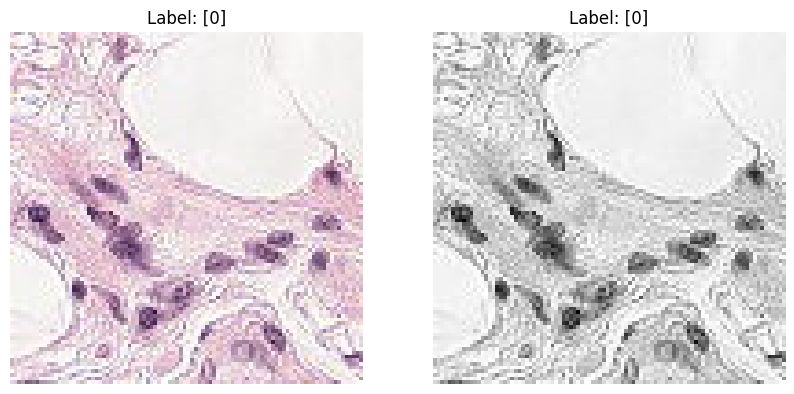

In [ ]:
for i in range(3):
    image_1 = X_train_raw[i]
    label_1 = y_raw[i]
    image_2 = X_train[i]
    label_2 = y_raw[i]

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(image_1)
    axes[0].set_title(f'Label: {label_1}')
    axes[0].axis('off')

    axes[1].imshow(image_2, cmap='gray')
    axes[1].set_title(f'Label: {label_2}')
    axes[1].axis('off')

    plt.show()

First I slice the data in multiple chunks.

The reason for this is to work with less data, when finding the optimal hyper-parameters.

Lets continue with **X_1** & **y_1** - and lets sort out the test data.

We want to use the same data, so we can compare the different models.

The code below is originally made for an ensemble with different subsets of the original data.

In [ ]:
x_train_copy = X_train
y_train_copy = y_raw

num_ensembles = 3
samples_per_ensemble = x_train_copy.shape[0] // num_ensembles

np.random.seed(42)

datasets = {}

for i in range(1, 4):
    indices = np.random.choice(x_train_copy.shape[0], samples_per_ensemble, replace=False)

    X_subset = x_train_copy[indices]
    y_subset = y_train_copy[indices]

    datasets[f'X_{i}'] = X_subset
    datasets[f'y_{i}'] = y_subset

    x_train_copy = np.delete(x_train_copy, indices, axis=0)
    y_train_copy = np.delete(y_train_copy, indices, axis=0)

In [ ]:
for i in range(1, 4):
    X = datasets[f'X_{i}']
    y = datasets[f'y_{i}']
    print(f"Shape of X_{i}: {X.shape}")
    print(f"Shape of y_{i}: {y.shape}")

Shape of X_1: (8738, 96, 96, 1)
Shape of y_1: (8738, 1)
Shape of X_2: (8738, 96, 96, 1)
Shape of y_2: (8738, 1)
Shape of X_3: (8738, 96, 96, 1)
Shape of y_3: (8738, 1)


As mentioned, lets sort out the test data for **X_1** & **y_1**:

In [ ]:
X_1 = datasets['X_1']
y_1 = datasets['y_1']

X1_train, X1_test, y1_train, y1_test= train_test_split(X_1, y_1, test_size=0.2, random_state=42)

# Base model:

**Lets resize the images to (32 x 32) for the Base model as Christian did:**

In [ ]:
def resize_and_normalize_image_32x32(image):
    image = tf.image.resize(image, [32, 32])
    return image / 255.0

def convert_dataset(data):
    dataset = tf.data.Dataset.from_tensor_slices(data)
    resized_dataset = dataset.map(resize_and_normalize_image_32x32)
    resized_dataset = resized_dataset.batch(32)
    return np.array(list(resized_dataset.unbatch().as_numpy_iterator()))

X1_train_32 = convert_dataset(X1_train)
X1_test_32 = convert_dataset(X1_test)

**Lets use optimal stopping:**

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                            patience=150,
                                            restore_best_weights=True)

weight_regularizer_1 = tf.keras.regularizers.L1(0.001)

In [ ]:
base_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 1), kernel_regularizer=weight_regularizer_1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),


    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=weight_regularizer_1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=weight_regularizer_1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=weight_regularizer_1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GlobalAveragePooling2D(),

    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(2, activation='softmax', kernel_regularizer=weight_regularizer_1),
])

optimizer = tf.keras.optimizers.experimental.Adadelta(
    learning_rate=0.0001)

base_model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_1 = base_model.fit(
    X1_train_32,
    y1_train,
    epochs=10000,
    verbose=1,
    validation_data=(X1_test_32, y1_test),
    callbacks=callback
)

base_model.summary()

Epoch 1/10000
219/219 [==============================] - 4s 8ms/step - loss: 11.2668 - accuracy: 0.4904 - val_loss: 11.0123 - val_accuracy: 0.4989
Epoch 2/10000
219/219 [==============================] - 1s 6ms/step - loss: 11.2657 - accuracy: 0.4941 - val_loss: 11.3483 - val_accuracy: 0.4989
Epoch 3/10000
219/219 [==============================] - 1s 7ms/step - loss: 11.2648 - accuracy: 0.4903 - val_loss: 11.2610 - val_accuracy: 0.4943
Epoch 4/10000
219/219 [==============================] - 1s 6ms/step - loss: 11.2423 - accuracy: 0.4967 - val_loss: 11.0842 - val_accuracy: 0.4880
Epoch 5/10000
219/219 [==============================] - 1s 6ms/step - loss: 11.2473 - accuracy: 0.5006 - val_loss: 11.1296 - val_accuracy: 0.4903
Epoch 6/10000
219/219 [==============================] - 2s 7ms/step - loss: 11.2641 - accuracy: 0.4888 - val_loss: 11.1308 - val_accuracy: 0.4914
Epoch 7/10000
219/219 [==============================] - 2s 7ms/step - loss: 11.2541 - accuracy: 0.4954 - val_loss: 11

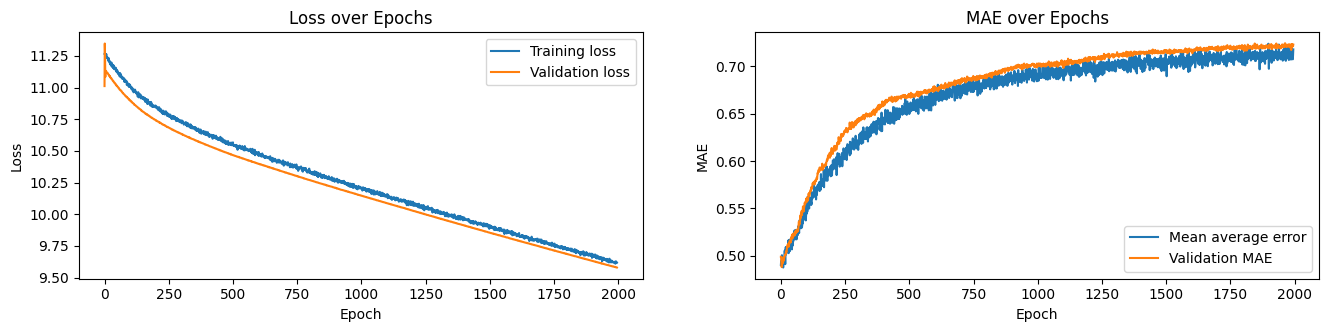

In [ ]:
history_x = history_1
history_y = history_1

fig = plt.figure(figsize=plt.figaspect(0.2))

ax = fig.add_subplot(1, 2, 1)
ax.plot(history_x.history['loss'], label='Training loss')
ax.plot(history_y.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Loss over Epochs')
plt.legend(loc='upper right')

ax = fig.add_subplot(1, 2, 2)
ax.plot(history_x.history['accuracy'], label='Mean average error')
ax.plot(history_y.history['val_accuracy'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title(f'MAE over Epochs')
plt.legend(loc='lower right')

plt.show()

# EfficientNet Model:


We know that the architecture of the model matters a lot, but how do we find out the optimal **Depth**, **Width** and **Resolution**.

The paper **EfficientNet** uses a single parameter **ϕ** to find out how to change the base model - that is depth, width and resolution.

<br>

See the script: **Efficientnet - calculations**

Written notes: **Efficientnet - formula and use**

<br>

In this case we use **ϕ** = 3.

In a grid search with **ϕ** = 3 we find out, that the best parameters - those parameters that closly live up to the formula constraints - are:

<br>

**How it works:**

<br>

Depth (d): Multiply the base depth of your network by α
. If your base network has a depth of D
 layers, the scaled depth will be D×α
.

Width (w): Multiply the base width (number of channels in convolutional layers or units in dense layers) by β
. If the base width is W
, the scaled width will be W×β
.

Resolution (r): Multiply the base resolution of your input data by γ
. If your network is designed for input images of size R×R
 pixels, the scaled resolution will be R×γ×R×γ
.

<br>

Alpha(α) = 1.2

Beta(β) = 1.4

Gamma(γ) = 1.6

<br>

## Back to our base model

Our new input images should be scaled with 1.6. Therefore the new input size will be 32 * 1.6 = 52 (apx).

The filters will be scaled by 1.4 - we can apply this directly in the model.

We have 5 primary layers and these will be scaled by 1.2 = 5 * 1.2 = 6.

Therefore we will include one more layer in the network

**Lets resize the input images:**

In [ ]:
def resize_and_normalize_image_52x52(image):
    image = tf.image.resize(image, [52, 52])
    return image / 255.0

def convert_dataset(data):
    dataset = tf.data.Dataset.from_tensor_slices(data)
    resized_dataset = dataset.map(resize_and_normalize_image_52x52)
    resized_dataset = resized_dataset.batch(52)
    return np.array(list(resized_dataset.unbatch().as_numpy_iterator()))

X1_train_52 = convert_dataset(X1_train)
X1_test_52 = convert_dataset(X1_test)

## EfficientNet Model:

In [ ]:
efficientnet_model = tf.keras.models.Sequential([
    #Extra layer:
    tf.keras.layers.Conv2D(filters=int(16 * 1.4), kernel_size=(3, 3), activation='relu', input_shape=(52, 52, 1), kernel_regularizer=weight_regularizer_1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(filters=int(32 * 1.4), kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=weight_regularizer_1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(filters=int(64 * 1.4), kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=weight_regularizer_1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(filters=int(128 * 1.4), kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=weight_regularizer_1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(filters=int(256 * 1.4), kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=weight_regularizer_1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GlobalAveragePooling2D(),

    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Dense(2, activation='softmax', kernel_regularizer=weight_regularizer_1),
])

optimizer = tf.keras.optimizers.experimental.Adagrad(0.0001)

efficientnet_model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_2 = efficientnet_model.fit(
    X1_train_52,
    y1_train,
    epochs=5000,
    verbose=1,
    validation_data=(X1_test_52, y1_test),
    callbacks=callback
)

efficientnet_model.summary()

In [ ]:
history_x = history_1
history_y = history_1

history_efficientnet_x = history_2
history_efficientnet_y = history_2

fig = plt.figure(figsize=plt.figaspect(0.2))

ax = fig.add_subplot(1, 2, 1)
ax.plot(history_x.history['loss'], label='Base Model Training loss')
ax.plot(history_y.history['val_loss'], label='Base Model Validation loss')
ax.plot(history_efficientnet_x.history['loss'], label='EfficientNet Training loss', linestyle='--')
ax.plot(history_efficientnet_y.history['val_loss'], label='EfficientNet Validation loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend(loc='upper right')

ax = fig.add_subplot(1, 2, 2)
ax.plot(history_x.history['accuracy'], label='Original Training Accuracy')
ax.plot(history_y.history['val_accuracy'], label='Original Validation Accuracy')
ax.plot(history_efficientnet_x.history['accuracy'], label='EfficientNet Training Accuracy', linestyle='--')
ax.plot(history_efficientnet_y.history['val_accuracy'], label='EfficientNet Validation Accuracy', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend(loc='lower right')

plt.show()

# STN Model:

We will consider a "Spatial Transformer Network":

<br>

See:

**Spatial Transformer Networks - paper**

**Spatial Transformer Networks - notes**

<br>

The main idea is, that we combine two networks, where the **location model (Loc)** is one network, where it will learn to augment the images using a 2*3 matrix - where it can zoom, rotate, shear and so on... It changes the values in the matrix to reduce the loss function - increasing the accuracy of the model. We do not define how to augment the images - we allow the network to figure that out! We can start with some values for the matrix. If we know, what could be a good idea. Zoom can sometimes be a good idea for example.

We create a function, were we can initialize the **biases matrix**, and another matrix of 6 entries with zeroes - **weights matrix**. The biases matrix is our initialized matrix with zoom, and the weights matrix has to match in dimentions, as this will be the weights for each "neuron", having an impact on how to augment the final biases matrix. The function below is created for us to define two positions in the biases matrix - the values for zoom. We will set these to zero, as we do not have any priors.

In [ ]:
def initialize_weights(input_nodes: int, default_zoom: float):
    biases = np.zeros((2, 3), dtype='float32') # this line creates a 2x3 matrix filled with zeros.
    biases[0, 0] = default_zoom # these lines set the first and the fifth elements of the biases matrix to default_zoom.
    biases[1, 1] = default_zoom # ...these lines
    weights = np.zeros((input_nodes, 6), dtype='float32') # this creates a matrix of weights with dimensions input_nodes x 6, also filled with zeros.

    return [weights, biases.flatten()]

**Below is the network for our images augmentation - the location network (Loc):**

<br>

This network transforms the input images of dimention 32 x 32 in this case. We end up with two dense layers, where 32 represent the final weights that construct the values for our final matrix for augmentation (6 values). The only reason that we use the **initialize_weights** function, it to include a prior. In fact we could just delete this part - as we set the priors as 0 in this case. As mentioned zoom can - in some cases - be a good idea (zoom is also called scaling). This is just a simple network to define our 2 x 6 matrix for image augmentation.

In [ ]:
def build_loc_model(default_zoom):
    loc_model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(8, kernel_size=7),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Conv2D(10, kernel_size=5),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(6, activation='linear',
                              weights=initialize_weights(32, default_zoom)),
        ])

    return loc_model

**Below is the "Base Model" made as a function for us to make a combined network:**

In [ ]:
def build_my_cnn_model():
    cnn_model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 1), kernel_regularizer=weight_regularizer_1),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Conv2D(filters=48, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=weight_regularizer_1),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=weight_regularizer_1),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=weight_regularizer_1),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=weight_regularizer_1),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.GlobalAveragePooling2D(),

        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Dense(2, activation='softmax', kernel_regularizer=weight_regularizer_1),
    ])

    return cnn_model

**Combine the "location network" and the "CNN network" to become a Spatial Transformer Network**:

<br>

First we have **loc_model** that takes the **default_zoom** value, as the global function also does. This is a parameter we can use, if we want to zoom. Again, we set it as 0 in this case (when the function is called).

We also build our **cnn_model**.

Then we define our input - the images - and the shape of those = 32 x 32.

We define **x** which is a vector - or in other words - our augmented images.

Thereafter we apply BilinearInterpolation.

Hereafter we use **spatial_transform**

- Represents the entire spatial transformation process of your STN. It takes an input image, processes it through the localization network and the bilinear interpolation to apply the spatial transformation, and outputs the transformed image. This model encapsulates the core functionality of the Spatial Transformer Network, which is to modify the input data spatially before it is fed into subsequent layers or models (like a CNN for classification or detection tasks).

The rest is pretty clear - as our transformed images are the input in our CNN. Recall that we return also **loc_model** to take a look at the augmentation further below.




In [ ]:
def build_stn_model(default_zoom):
  loc_model = build_loc_model(default_zoom)
  cnn_model =  build_my_cnn_model()

  image = tf.keras.layers.Input(shape=(32, 32, 1))
  x = loc_model(image)
  x = BilinearInterpolation((32, 32))([image, x])
  spatial_transform = tf.keras.models.Model(
        inputs=image, outputs=x, name='spatial_transformer',
  )

  stn_model = tf.keras.models.Sequential([
        spatial_transform,
        cnn_model,
        ])

  return stn_model, loc_model

In [ ]:
stn_model, loc_model = build_stn_model(0)

In [ ]:
optimizer = tf.keras.optimizers.experimental.Adadelta(learning_rate=0.00001)

stn_model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_3 = stn_model.fit(
    X1_train_32,
    y1_train,
    epochs=10000,
    verbose=1,
    validation_data=(X1_test_32, y1_test),
    callbacks=callback
)

Epoch 1/10000
219/219 [==============================] - 8s 13ms/step - loss: 11.0422 - accuracy: 0.5282 - val_loss: 10.7878 - val_accuracy: 0.5011
Epoch 2/10000
219/219 [==============================] - 2s 11ms/step - loss: 11.0448 - accuracy: 0.5266 - val_loss: 10.9179 - val_accuracy: 0.5011
Epoch 3/10000
219/219 [==============================] - 2s 10ms/step - loss: 11.0242 - accuracy: 0.5409 - val_loss: 10.9097 - val_accuracy: 0.5149
Epoch 4/10000
219/219 [==============================] - 2s 10ms/step - loss: 11.0234 - accuracy: 0.5310 - val_loss: 10.8697 - val_accuracy: 0.5292
Epoch 5/10000
219/219 [==============================] - 2s 10ms/step - loss: 10.9996 - accuracy: 0.5379 - val_loss: 10.8965 - val_accuracy: 0.5034
Epoch 6/10000
219/219 [==============================] - 2s 10ms/step - loss: 11.0015 - accuracy: 0.5348 - val_loss: 10.8944 - val_accuracy: 0.5040
Epoch 7/10000
219/219 [==============================] - 2s 10ms/step - loss: 11.0159 - accuracy: 0.5368 - val_l

In [ ]:
history_x = history_1
history_y = history_1

history_efficientnet_x = history_2
history_efficientnet_y = history_2

history_stn_x = history_3
history_stn_y = history_3

fig = plt.figure(figsize=plt.figaspect(0.2))

ax = fig.add_subplot(1, 2, 1)
ax.plot(history_x.history['loss'], label='Base Model Training loss')
ax.plot(history_y.history['val_loss'], label='Base Model Validation loss')
ax.plot(history_efficientnet_x.history['loss'], label='EfficientNet Training loss', linestyle='--')
ax.plot(history_efficientnet_y.history['val_loss'], label='EfficientNet Validation loss', linestyle='--')
ax.plot(history_stn_x.history['loss'], label='STN Training loss', linestyle='dotted')
ax.plot(history_stn_y.history['val_loss'], label='STN Validation loss', linestyle='dotted')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend(loc='upper right')

ax = fig.add_subplot(1, 2, 2)
ax.plot(history_x.history['accuracy'], label='Base Model Training Accuracy')
ax.plot(history_y.history['val_accuracy'], label='Base Model Validation Accuracy')
ax.plot(history_efficientnet_x.history['accuracy'], label='EfficientNet Training Accuracy', linestyle='--')
ax.plot(history_efficientnet_y.history['val_accuracy'], label='EfficientNet Validation Accuracy', linestyle='--')
ax.plot(history_stn_x.history['accuracy'], label='STN Training Accuracy', linestyle='dotted')
ax.plot(history_stn_y.history['val_accuracy'], label='STN Validation Accuracy', linestyle='dotted')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend(loc='lower right')

plt.show()

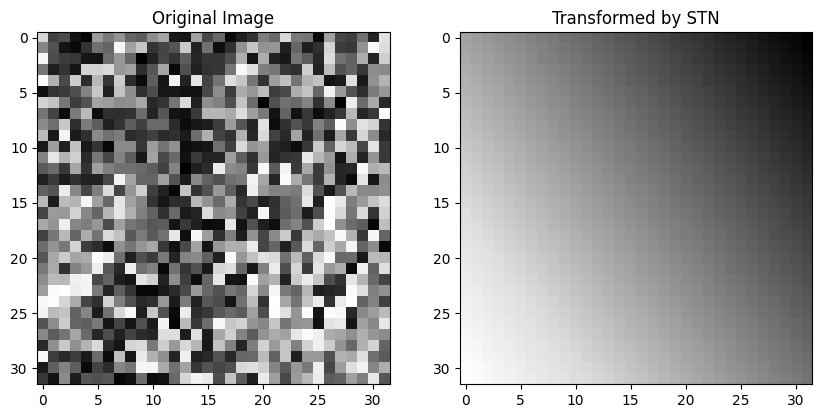

In [ ]:
out_post_train = stn_model.get_layer('spatial_transformer')(X1_test_32[0:1]).numpy()[0, :, :, 0]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(np.squeeze(X1_test_32[0]), cmap='gray')
axes[0].set_title('Original Image')

axes[1].imshow(out_post_train, cmap='gray')
axes[1].set_title('Transformed by STN')

plt.show()

1/1 [==============================] - 0s 60ms/step


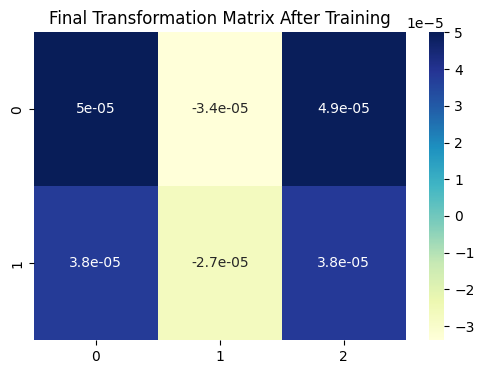

In [ ]:
sample_input = X1_test_32[0:1]
final_matrix = loc_model.predict(sample_input)
final_matrix = final_matrix.reshape(2, 3)

plt.figure(figsize=(6, 4))
sns.heatmap(final_matrix, annot=True, cmap="YlGnBu")
plt.title("Final Transformation Matrix After Training")
plt.show()

# Next:

**Skiped Layers Model**

**Transformer Model**